# French baby names evolution 1915-2015

## Project

Inspired by an example on US baby names from the excellent book [Python for Data Analysis](http://shop.oreilly.com/product/0636920050896.do) by Wes McKinney, I have downloaded a file of [French baby names](https://www.data.gouv.fr/fr/datasets/fichier-des-prenoms-edition-2016/) since 1900 and done a bit of data wrangling to look at some interesting trends. A lot more could be analysed with this file, but I focused on a few noteworthy patterns.

## Results

* Overall a massive increase in diversity of baby names since 1915: top 100 names used to represent 90% of births. A century later, they only account to 60% of births.
* For females, while almost all names ended with an "e", it is now about one third, superseeded by names ending with "a".
* Very clear trends for some baby-boom flavoured names like "Jean-xxx":   
![](jean.png)

## Full code

### Setup and libraries

We will be using the standard libraries for data analysis, including `Matplotlib` and `seaborn` for graphs.

In [311]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series, DataFrame

# Plots parameters
%matplotlib inline

### Load data

The downloaded txt file is about 13 Mb heavy. We load it with `pandas`, with tabs as separator and `Latin1` as encoding, which is not the default behaviour.

In [312]:
# Load file
full_data = pd.read_csv('./data/nat2015.txt', sep='\t', encoding='latin_1')

# Size of the dataframe
print("Dataframe has {} rows and {} columns\n".format(full_data.shape[0], full_data.shape[1]))

# Are there any missing observations ?
print("Missing observations:\n", full_data.isnull().sum())

Dataframe has 589411 rows and 4 columns

Missing observations:
 sexe        0
preusuel    3
annais      0
nombre      0
dtype: int64


In [313]:
# Show head of dataframe
full_data.head(8)

,sexe,preusuel,annais,nombre
0,1,A,1980,3.0
1,1,A,1998,3.0
2,1,A,XXXX,21.0
3,1,AADEL,1976,5.0
4,1,AADEL,1978,3.0
5,1,AADEL,1980,3.0
6,1,AADEL,1981,5.0
7,1,AADEL,1982,4.0


As usually, we need to do some cleaning on the data, even though it is already quite tidy. 

In [314]:
# Rename columns to english words
full_data.columns = ['gender', 'name', 'year', 'count']

# Convert genders to 'M' or 'F'
full_data['gender'] = np.where(full_data['gender'] == 1, 'M', 'F')

# Convert names to Title Case
full_data['name'] = full_data['name'].str.title()

# Remove rows without year information
mask = full_data[full_data['year'] == 'XXXX'].index
full_data = full_data.drop(mask)

# Remove names that are only 1 character long (most likely an error) or missing
full_data = full_data[full_data['name'].str.len() > 1]

# Remove years before 1915, as data is not reliable enough
full_data['year'] = pd.to_numeric(full_data['year'])
full_data = full_data[full_data['year'] >= 1915]

# Show head
full_data.head(8)

,gender,name,year,count
3,M,Aadel,1976,5.0
4,M,Aadel,1978,3.0
5,M,Aadel,1980,3.0
6,M,Aadel,1981,5.0
7,M,Aadel,1982,4.0
8,M,Aadel,1983,3.0
9,M,Aadel,1987,5.0
11,M,Aadil,1974,4.0


### Analysis

#### Number of births per year

Let's begin by looking at the most obvious trend: the number of births by year and gender. To plot this, we can create a handy `pivot_table` with genders in columns, in order to plot two distinct lines.

In [315]:
# Prepare data for graph
graph = full_data.pivot_table('count', index='year', columns='gender', aggfunc='sum')

# Show head
graph.head()

gender,F,M
year,,
1915,182426.0,169229.0
1916,146267.0,136540.0
1917,158170.0,148478.0
1918,178680.0,170117.0
1919,197084.0,188768.0


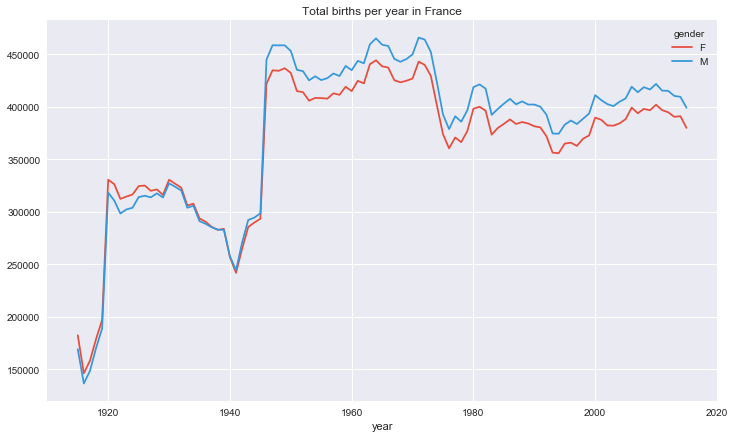

In [316]:
# Plot number of birth by year and gender
pal = ["#e74c3c", "#3498db", "#95a5a6", "#9b59b6", "#34495e", "#2ecc71"]
sns.set_palette(pal)
fig = plt.figure(figsize = (12, 7))
ax = fig.add_subplot(1, 1, 1)
graph.plot(ax = ax, title = "Total births per year in France")

A few obvious observations can be made from this plot:   
* Massive drops in births during WW2 and WW2
* The "baby-boom" generation between 1945 and ~1973
* Since 1945, about 5% more male over female births

#### Popularity of names

We can now extract the most popular names, and see how they evolved over 100 years. To cancel the effects of overall natality trends, we need to compute the proportion that each name represent over all births for each year, for each gender.

In [317]:
### For each name, compute fraction of birth per year and gender
def add_prop(group): 
    group['prop'] = group['count'] / group['count'].sum()
    return group 

full_data = full_data.groupby(['year', 'gender']).apply(add_prop)

In [318]:
### Extract Top 100 names for each year/gender, in order to facilitate further analysis
def get_top(group):
    return group.sort_values(by='count', ascending=False)[:200]

top_names = full_data.groupby(['year', 'gender']).apply(get_top).reset_index(drop=True)

In [319]:
### Show most frequent names 
(top_names[top_names['name'] != "_Prenoms_Rares"]
     .pivot_table('count', index=['name', 'gender'], aggfunc='sum')
     .sort_values(by=['count'], ascending=False)
     .reset_index()
     .head(10))

,name,gender,count
0,Jean,M,1638609.0
1,Marie,F,1527706.0
2,Michel,M,800202.0
3,Pierre,M,736478.0
4,André,M,563626.0
5,Philippe,M,530215.0
6,Alain,M,502078.0
7,Bernard,M,454990.0
8,Jacques,M,452754.0
9,Daniel,M,422028.0


Let's plot the 100-year trends of some of these popular names. 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a47f2f668>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1a3a97b240>], dtype=object)

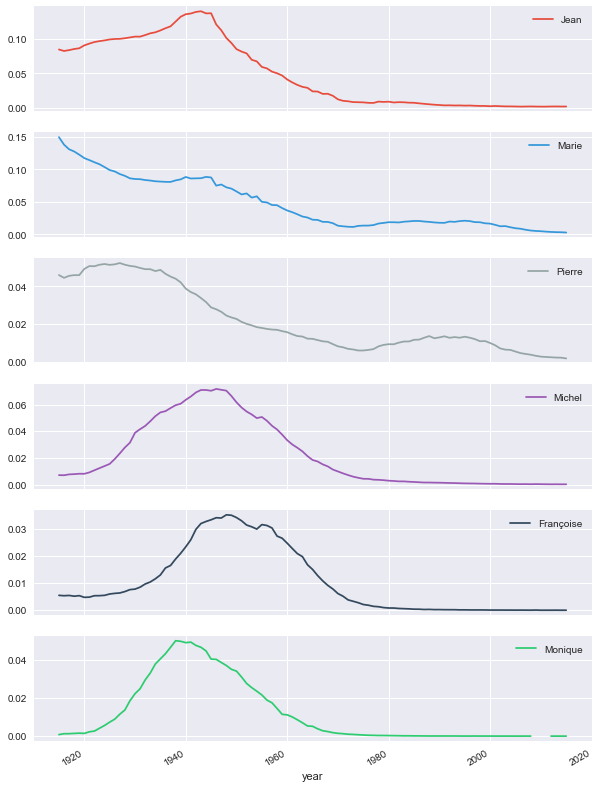

In [320]:
# Plot trends of most frequent names
graph = (full_data
         .pivot_table('prop', index='year', columns='name', aggfunc='sum')
         [['Jean', 'Marie', 'Pierre', 'Michel', 'Françoise', 'Monique']])
graph.plot(subplots=True, figsize=(10, 15), sharey=False)

Quite intuitively (for French, at least) very traditional names like Jean, Marie and Pierre have seen a consistent decrease of popularity over the 20th century, while names like Michel, Françoise or Monique totally have a baby-boomer tone, and have almost disappeared since then.

Another baby-boomer star name for males was the declination around "Jean-XXXX" like Jean-Pierre or Jean-Michel, as confirmed by the aggregrated graph below.

Text(1960,0.03,'75% of births \nbetween 1945 and 1975')

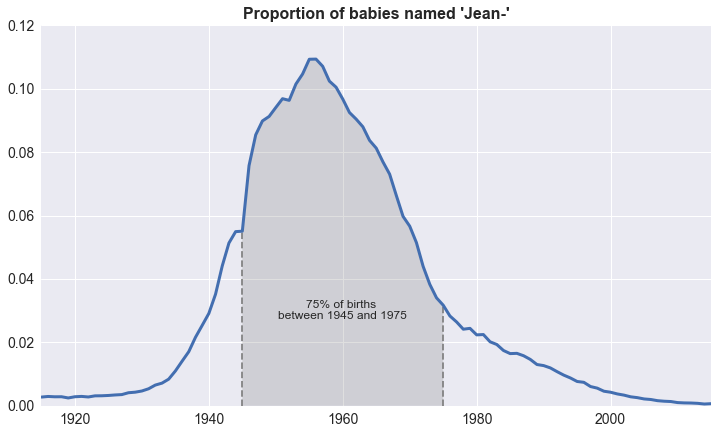

In [330]:
### Plot trend for all names starting with "Jean-"

# Filter data
mask = full_data['name'].str.startswith("Jean-")
graph = full_data[mask].pivot_table('prop', index=['year'], aggfunc='sum')

# Compute distribution
graph['cumsum'] = graph['prop'].cumsum() / graph['prop'].sum()
qt1 = graph[graph['cumsum'] >= 0.125].head(1)
qt3 = graph[graph['cumsum'] >= 0.875].head(1)


# Setup plot
fig = plt.figure(figsize = (12, 7))
ax = fig.add_subplot(1, 1, 1)
graph.index.name = ''
ax.set_title("Proportion of babies named 'Jean-'", fontsize=16, fontweight='bold')

# Main plot
graph.plot(x=graph.index, y='prop', ax=ax, xlim=(1915, 2015), ylim=(0, 0.12),
           lw=3, fontsize=14, legend=False, color=['#436eb0'])

# Plot 1st and 3rd quartiles
ax.vlines(x=qt1.index[0], ymin=0, ymax=qt1['prop'], color='grey', linestyles='dashed')
ax.vlines(x=qt3.index[0], ymin=0, ymax=qt3['prop'], color='grey', linestyles='dashed')
ax.fill_between(graph.index, graph['prop'], alpha=0.25, facecolor='grey',
                where=((graph.index >= qt1.index[0]) & (graph.index <= qt3.index[0])))
ax.text(1960, 0.03, '75% of births \nbetween 1945 and 1975', 
        ha='center', va='center', fontsize=12)

#### Diversity in names

We have a hint that in 2015, baby names are much more diverse than a century ago. In order to confirm this intuition, we can compute how much of the overall births the top 100 most common names represent, for each year.

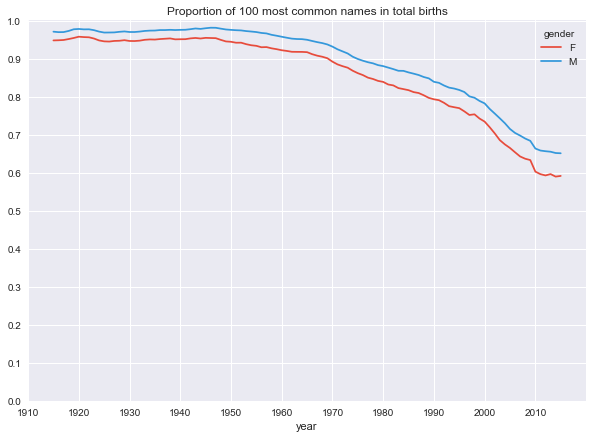

In [322]:
### Plot proportion of total birth for top 100 names
graph = top_names.pivot_table('prop', index='year', columns='gender', aggfunc='sum')
graph.plot(figsize=(10,7), title='Proportion of 100 most common names in total births',
           xticks=range(1910, 2020, 10), yticks=np.linspace(0, 1, 11))

As expected, there is much more variety in names today: while in 1915, ~95% of babies had "Top 100" names, this proportion has dropped to 60%-65% in 2015. Note that females consistently have a slightly higher diversity in names.

As a complement, we can also plot the number of names used for the top 50% of births. While in 1915 it was only around 15 distinct names, it is now up to almost 120 names for females!

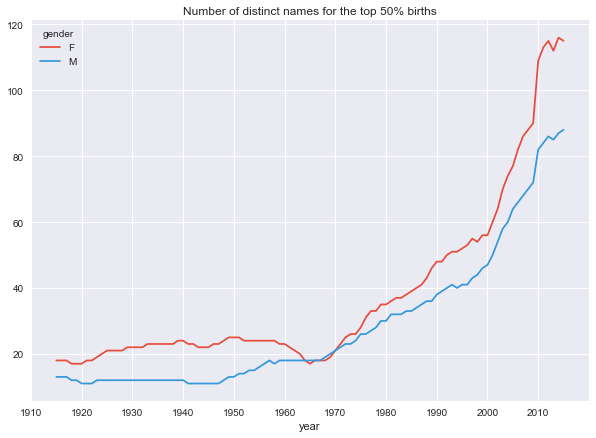

In [323]:
### Plot the number of names in the top 50% of births
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group['prop'].cumsum().values.searchsorted(q) + 1 

graph = (top_names
         .groupby(['year', 'gender'])
         .apply(get_quantile_count)
         .unstack('gender'))

graph.plot(figsize=(10,7), title='Number of distinct names for the top 50% births',
           xticks=range(1910, 2020, 10))


#### Last letter revolution

Another trend that can be explored, related to the diversity in names, is the most common *last* letter of names. To do this, we will extract the last letter for each name, calculate their variation (in proportion for all births on a given year) for a few years, and plot the full trends for the largest variations.

In [324]:
### Extract last letter for all names

# Function to extract last letter
get_last_letter = lambda x: x[-1].upper()
last_letters = full_data['name'].map(get_last_letter)

# Create pivot table of last letters count by gender and year
table = full_data.pivot_table('prop', index=last_letters, columns=['gender', 'year'], aggfunc='sum')

In [325]:
### Get last letters with biggest changes

# Pivot table with last letter count, for 4 years
top_letters = (full_data
               .pivot_table('prop', index=['gender', last_letters], columns=['year'], aggfunc='sum')
               .reindex(columns=[1920, 1950, 1980, 2010], level=None)
               .fillna(0))

# Calculate proportion
top_letters = top_letters.divide(top_letters.sum())

# Calculate cumumated sum of absolute variations
top_letters['delta'] = abs(top_letters.iloc[:, 0] - top_letters.iloc[:, 3])
top_letters['cum_delta'] = abs(top_letters - top_letters.shift(1, axis=1)).sum(axis=1)

# Sort by largest variations
top_letters = top_letters.reset_index(level='gender').sort_values(by=['delta'], ascending=False)

# Display
top_letters.head(6)

year,gender,1920,1950,1980,2010,delta,cum_delta
name,,,,,,,
E,F,0.468938,0.445962,0.331438,0.166246,0.302692,0.439137
A,F,0.020459,0.010653,0.097037,0.191149,0.170690,0.210761
O,M,0.000809,0.002978,0.005748,0.056995,0.056186,0.056995
É,M,0.053783,0.020803,0.002914,0.001783,0.052001,0.102219
S,F,0.004462,0.005080,0.011463,0.051508,0.047046,0.051508
N,M,0.080852,0.097837,0.103746,0.127540,0.046687,0.127540


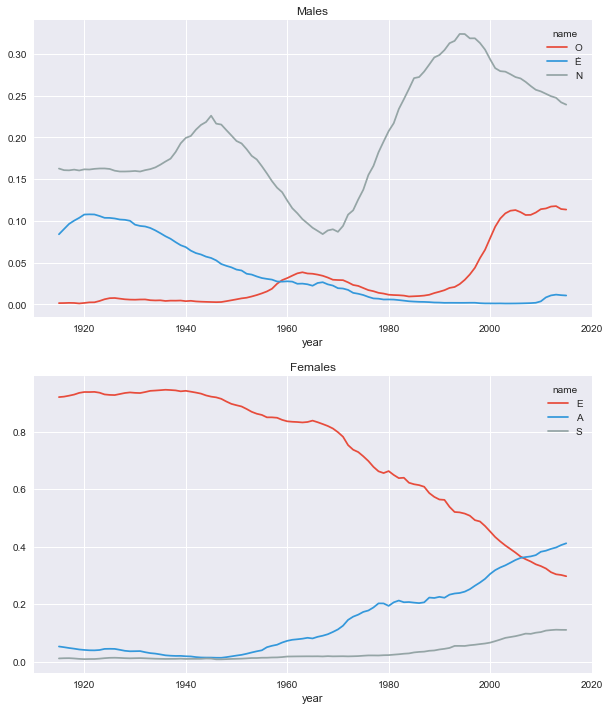

In [326]:
### Plot trends for top letters variations

# Get top letters for Males and Females
top_f = top_letters[top_letters['gender'] == 'F'].head(3).index.tolist()
top_m = top_letters[top_letters['gender'] == 'M'].head(3).index.tolist()

# Get table with every year
graph = table / table.sum()

# Plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
graph.loc[top_m, 'M'].T.plot(ax=axes[0], title='Males')
graph.loc[top_f, 'F'].T.plot(ax=axes[1], title='Females')

The most impressive trends is for female babies, with names ending with an "e" dropping from 90% to 30%, and replaced for the most part by names ending with an "a".